# Bike-Rental Volume Prediction

The purpose of this notebook is to provide an illustration of how the FRESH algorithm can be implemented to aid in forecasting the value of a target variable without the implementation of data rolling and for data which contains inconsistent evenly spaced data points.

---

## Loading library scripts and data

In the following cell, the kdb+/q machine learning toolkit (ML-Toolkit) is loaded in to allow the use of functions provided in both the FRESH and Utilities sections of the library. Graphics functions have also been loaded in for the purpose of this notebook.

Data pertaining to a bike sharing scheme in Washington DC between 2011-2012 is used (found on [Kaggle](https://www.kaggle.com/marklvl/bike-sharing-dataset)). The goal is to use the hourly data from the current day to predict if the last hour of the next day will be busier or quieter than the last hour of today.

This use case, while slightly contrived and chosen to show the operation of this algorithm, could potentially be useful in allowing an employer to anticipate if extra staff are required for the next business day, which could save on costs.

In [1]:
\c 15 100
\l ../../ml.q
.ml.loadfile`:init.q
\l graphics.q

/ turn off any python warnings
warn:.p.import[`warnings];
warn[`:filterwarnings]["ignore"];

In [2]:
tabinit:("IDIIIIIIIIFFFFIII";enlist ",") 0:`:SampleDatasets/bike_rental.csv

/ drop columns which contain zero variance as these will not be useful when used with a machine learning algorithm
show tabinit:flip (where 0=var each flip tabinit) _ flip tabinit

instant dteday     season yr mnth hr holiday weekday workingday weathersit temp atemp  hum  winds..
-------------------------------------------------------------------------------------------------..
1       2011.01.01 1      0  1    0  0       6       0          1          0.24 0.2879 0.81 0    ..
2       2011.01.01 1      0  1    1  0       6       0          1          0.22 0.2727 0.8  0    ..
3       2011.01.01 1      0  1    2  0       6       0          1          0.22 0.2727 0.8  0    ..
4       2011.01.01 1      0  1    3  0       6       0          1          0.24 0.2879 0.75 0    ..
5       2011.01.01 1      0  1    4  0       6       0          1          0.24 0.2879 0.75 0    ..
6       2011.01.01 1      0  1    5  0       6       0          2          0.24 0.2576 0.75 0.089..
7       2011.01.01 1      0  1    6  0       6       0          1          0.22 0.2727 0.8  0    ..
8       2011.01.01 1      0  1    7  0       6       0          1          0.2  0.2576 0.86 0    ..


---

## Set target values for forecasting

The next step is to define the target vector which will be predicted by the model. In this case, we are attempting to predict if the number of bike rentals in the last hour of business will be higher or lower tomorrow than it was today.

In [3]:
lasthour:value exec last cnt by dteday from tabinit
targets:lasthour>prev lasthour

By using the naive solution, i.e stating that the number of rentals will only ever increase, we would be correct ~56% of the time. As such, if our procedure and algorithm have provided us with any new insights into the data our predictions will be more than 56% correct on a consistent basis. 

In [4]:
update pcnt:100*num%sum num from select num:count i by target from ([]target:targets)

target| num pcnt    
------| ------------
0     | 319 43.63885
1     | 412 56.36115


---

## Assign extracted features and complete extraction

To extract features provided in the FRESH library from the dataset, `.ml.fresh.params` must be called. This is a table that contains the available functions and corresponding parameters to be applied to the data. The parameters and functions to be applied to the dataset can also be altered by updating the valid column of this table. An example is shown below.

In [5]:
show ptab:.ml.fresh.params

/ make any function invalid that you do not want applied to the data
ptab:update valid:0b from ptab where f in `c3`numpeaks`quantile`fftcoeff`spktwelch`ratiobeyondsigma`augfuller

f             | pnum pnames pvals valid
--------------| -----------------------
absenergy     | 0                 1    
abssumchange  | 0                 1    
aggautocorr   | 0                 1    
augfuller     | 0                 1    
count         | 0                 1    
countabovemean| 0                 1    
countbelowmean| 0                 1    
fftaggreg     | 0                 1    
firstmax      | 0                 1    
firstmin      | 0                 1    
..


In [6]:
\t tabraw:.ml.fresh.createfeatures[tabinit;`dteday;2_ cols tabinit;ptab]
show tabraw
-1"The number of rows in the data is: ",string count tabraw;
-1"The number of targets which are to be predicted is: ",string count lasthour;

48021


dteday    | season_absenergy season_abssumchange season_count season_countabovemean season_countb..
----------| -------------------------------------------------------------------------------------..
2011.01.01| 24               0                   24           0                     0            ..
2011.01.02| 23               0                   23           0                     0            ..
2011.01.03| 22               0                   22           0                     0            ..
2011.01.04| 23               0                   23           0                     0            ..
2011.01.05| 23               0                   23           0                     0            ..
2011.01.06| 23               0                   23           0                     0            ..
2011.01.07| 23               0                   23           0                     0            ..
2011.01.08| 24               0                   24           0                     0            ..


---

## Complete feature significance tests

Upon completion of the feature extraction algorithm, the importance of each feature can be determined using the statistical tests contained in the `.ml.fresh.significantfeatures` function. This will reduce the number of features that are passed to the machine learning algorithm. By setting the third parameter of the function to `.28`, the function will return features with a p-value within the top 28th percentile.

In [7]:
show tabreduced:key[tabraw]!(.ml.fresh.significantfeatures[t;targets;.ml.fresh.percentile .28])#t:value tabraw
-1 "The number of columns in the initial dataset is: ",string count cols tabinit;
-1 "The number of columns in the unfiltered dataset is: ",string count cols tabraw;
-1 "The number of columns in the filtered dataset is: ",string count cols tabreduced;

dteday    | weekday_absenergy weekday_max weekday_mean weekday_med weekday_min weekday_sumrecurri..
----------| -------------------------------------------------------------------------------------..
2011.01.01| 864               6           6            6           6           144               ..
2011.01.02| 0                 0           0            0           0           0                 ..
2011.01.03| 22                1           1            1           1           22                ..
2011.01.04| 92                2           2            2           2           46                ..
2011.01.05| 207               3           3            3           3           69                ..
2011.01.06| 368               4           4            4           4           92                ..
2011.01.07| 575               5           5            5           5           115               ..
2011.01.08| 864               6           6            6           6           144               ..


---

## Prepare data for model

Before passing data to the machine learning algorithm for training it must first be converted to a matrix. Null values should also be filled and infinities replaced.

Once this has been done, the data must be split into training and testing sets. Below we use 0.2% as the size of data to be used in the testing set.

In [8]:
mattab:{flip value flip x}

/ remove nulls and replace infinities
fitvalsfilter:0^mattab[value tabreduced]
fitvalsfilter:.ml.infreplace[fitvalsfilter]

/ split into training and testing sets
dict1:.ml.traintestsplit[fitvalsfilter;targets;.2];

---

## Train and make predictions on the model

Below a Random Forest Classifier is initialized with 200 estimators. This allows for an estimate of the quality of the data to be made following the completion of feature extraction.

The addition of ``` `verbose pykw 1 ``` in the definition of the model allows for the time required for the training of the classifier and the associated training loss to be displayed if desired.

In [9]:
clf:.p.import[`sklearn.ensemble][`:RandomForestClassifier][`n_estimators pykw 200;`random_state pykw 1]

Once initialized, we can fit data to the model and then use the trained model to make predictions.

In [10]:
clf[`:fit][dict1[`xtrain];dict1[`ytrain]]`;
pred1:clf[`:predict][dict1[`xtest]]`

---

## Results

Below we can compare the actual and predicted values of the classifications using a range of metrics and display the results in a confusion matrix.

In [11]:
.ml.classreport[dict1[`ytest];pred1]
-1"The number of misclassifications in the filtered dataset is: ",string .ml.sse[dict1[`ytest];pred1];
-1"The accuracy in the filtered dataset is: ",string .ml.accuracy[dict1[`ytest];pred1];

The number of misclassifications in the filtered dataset is: 30
The accuracy in the filtered dataset is: 0.7959184


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7272727 0.8       0.7619048 60     
1        | 0.8518519 0.7931034 0.8214286 87     
avg/total| 0.7895623 0.7965517 0.7916667 147    


tn| 48
fp| 12
fn| 18
tp| 69


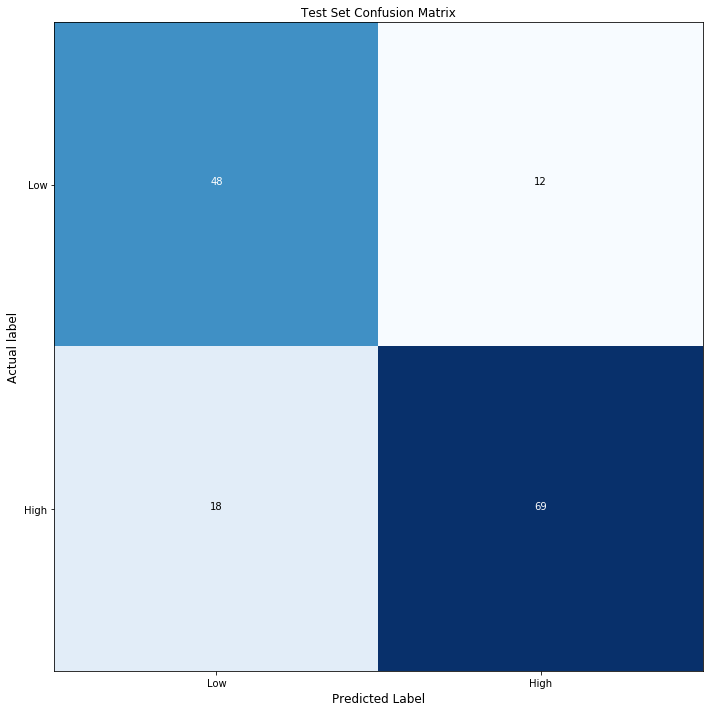

In [12]:
cnfM:.ml.confmat[dict1[`ytest];pred1]
.ml.confdict[dict1[`ytest];pred1;1b]
.ml.displayCM[value cnfM;`Low`High;"Test Set Confusion Matrix";()]

## Conclusions

It can be seen from the above results that the use of a Random Forest Classifier allowed us to predict last hour of business today vs the previous day to a high accuracy compared to the naive case detailed above.

**Note:** The quality of results gathered from performing the classifications depends on the location where the data is split. This is an inherent problem in making predictions on systems influended by human behaviour as it is difficult to predict outlying cases which have a non-repeating signatures.

---